In [2]:
import json
import os
import csv
import rdflib
from rdflib import Graph, URIRef, Literal, Namespace, BNode, Dataset
from rdflib.namespace import SKOS, DCTERMS, DCMITYPE, RDF, RDFS, XSD, PROV, SDO, TIME, split_uri

from openai import OpenAI
from langchain_community.graphs import RdfGraph

import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from uk2us import uk_us

import requests
import xml.etree.ElementTree as ET
from html.parser import HTMLParser
from html import unescape
import re
from keybert import KeyBERT

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
from collections import defaultdict

import lemminflect
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

import itertools
import pandas as pd
from urllib.parse import urlparse

In [2]:
# Opening config file, the config structure is:
# {"access_token_zenodo":"......"
# "openai_api_key":"......"}

config = open('config', 'r')
config = json.load(config)

os.environ['OPENAI_API_KEY'] = config['openai_api_key']

In [3]:
# Load the JSON dataset
with open('benchmarks/text_RDF_gs.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Access the dataset
dataset = data['dataset']

In [4]:
def load_graph(data):
    g = rdflib.Graph()
    g.parse(data=data, format="turtle")
    return g

In [5]:
def print_rdf(rdf):
    g = rdflib.Graph()
    g.parse(data=rdf, format="turtle")

    for s, p, o in g:
        print(s, p, o)

In [6]:
# Namespaces
she = Namespace("https://soilwise-he.github.io/soil-health#")
agrovoc = Namespace("http://aims.fao.org/aos/agrovoc/")
agrontology = Namespace("http://aims.fao.org/aos/agrontology#")
sio = Namespace("http://semanticscience.org/resource/")
glosis_lh = Namespace("http://w3id.org/glosis/model/layerhorizon/")
glosis_sp = Namespace("http://w3id.org/glosis/model/siteplot/")
qudt = Namespace("http://qudt.org/schema/qudt/")
unit = Namespace("http://qudt.org/vocab/unit/")
iso11074 = Namespace("https://data.geoscience.earth/ncl/ISO11074v2025/")
obo = Namespace("http://purl.obolibrary.org/obo/")
wdt = Namespace("http://www.wikidata.org/prop/direct/")
biolink = Namespace("https://w3id.org/biolink/vocab/")
afox = Namespace("http://purl.allotrope.org/ontologies/property#")
afor = Namespace("http://purl.allotrope.org/ontologies/result#")
sorelsc = Namespace("http://sweetontology.net/relaSci/")
sorelpr = Namespace("http://sweetontology.net/relaProvenance/")
sohuj = Namespace("http://sweetontology.net/humanJurisdiction/")
sorelph = Namespace("http://sweetontology.net/relaPhysical/")
sorelm = Namespace("http://sweetontology.net/relaMath/")
sorepsg = Namespace("http://sweetontology.net/reprSpaceGeometry/")
bao = Namespace("http://www.bioassayontology.org/bao#")
repr = Namespace("https://w3id.org/reproduceme#")
sorelch = Namespace("http://sweetontology.net/relaChemical/")
sorelsp = Namespace("http://sweetontology.net/relaSpace/")
om = Namespace("http://www.ontology-of-units-of-measure.org/resource/om-2/")
afop = Namespace("http://purl.allotrope.org/ontologies/process#")
gemet = Namespace("http://www.eionet.europa.eu/gemet/concept/")
inrae = Namespace("http://opendata.inrae.fr/thesaurusINRAE/")

In [7]:
from rdflib.exceptions import ParserError

# --- Load and Prepare Data ---
try:
    dataset_list = data.get("dataset", [])
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    dataset_list = []

# --- Initialize Counters ---
total_word_count = 0
total_triple_count = 0
# **MODIFIED**: Renamed variables for clarity
sum_of_unique_subjects_per_graph = 0 # Sum of unique subjects count per graph
sum_of_unique_relationships_per_graph = 0 # Sum of unique relationships count per graph

num_datasets_processed = 0
num_valid_rdf_graphs = 0 # Count only graphs that parse successfully

# --- Process Each Dataset Entry ---
if not dataset_list:
    print("No datasets found in the JSON data.")
else:
    for entry in dataset_list:
        num_datasets_processed += 1

        # 1. Calculate word count for "text"
        text = entry.get("text", "")
        words = text.split()
        total_word_count += len(words)

        # 2. Process "rdf_graph_turtle"
        turtle_data = entry.get("rdf_graph_turtle", "")
        if turtle_data:
            g = Graph()
            try:
                g.parse(data=turtle_data, format="turtle")
                num_valid_rdf_graphs += 1

                # Count triples for this specific graph
                current_triple_count = len(g)
                total_triple_count += current_triple_count

                # **MODIFIED**: Find unique subjects and relationships (predicates)
                # for this specific graph
                current_unique_subjects = set() # Changed name
                current_unique_relationships = set()

                for s, p, o in g:
                    # s, p, o are rdflib terms (URIRef, Literal, BNode)
                    current_unique_subjects.add(s) # **MODIFIED**: Only add subject
                    # Object (o) is no longer added to this set
                    current_unique_relationships.add(p)

                # Add the counts from this graph to the overall sum
                # **MODIFIED**: Use the unique subjects count
                sum_of_unique_subjects_per_graph += len(current_unique_subjects)
                sum_of_unique_relationships_per_graph += len(current_unique_relationships)

            except ParserError as e:
                print(f"Warning: Could not parse RDF graph in entry {num_datasets_processed}: {e}")
            except Exception as e:
                print(f"Warning: An unexpected error occurred processing RDF graph in entry {num_datasets_processed}: {e}")
        else:
             print(f"Warning: Entry {num_datasets_processed} has no 'rdf_graph_turtle' data.")


    # --- Calculate Averages ---
    # Avoid division by zero
    avg_word_count = total_word_count / num_datasets_processed if num_datasets_processed > 0 else 0
    avg_triple_count = total_triple_count / num_valid_rdf_graphs if num_valid_rdf_graphs > 0 else 0
    # **MODIFIED**: Calculate average unique subjects
    avg_unique_subjects = sum_of_unique_subjects_per_graph / num_valid_rdf_graphs if num_valid_rdf_graphs > 0 else 0
    avg_unique_relationships = sum_of_unique_relationships_per_graph / num_valid_rdf_graphs if num_valid_rdf_graphs > 0 else 0

    # --- Print Results ---
    print(f"\n--- Analysis Results ---")
    print(f"Total dataset entries processed: {num_datasets_processed}")
    print(f"Average number of words in 'text': {avg_word_count:.2f}")
    print("-" * 20)
    print(f"Valid RDF graphs parsed: {num_valid_rdf_graphs}")
    if num_valid_rdf_graphs > 0:
        print(f"Average number of triples per graph: {avg_triple_count:.2f}")
        # **MODIFIED**: Updated print statement label
        print(f"Average number of unique subjects per graph: {avg_unique_subjects:.2f}")
        print(f"Average number of unique relationships (predicates) per graph: {avg_unique_relationships:.2f}")
    else:
        print("No valid RDF graphs found to calculate graph-based averages.")


--- Analysis Results ---
Total dataset entries processed: 105
Average number of words in 'text': 140.82
--------------------
Valid RDF graphs parsed: 105
Average number of triples per graph: 92.06
Average number of unique subjects per graph: 28.61
Average number of unique relationships (predicates) per graph: 15.52


### Convert text to RDF triples using LLMs

In [13]:
# System prompt for zero-shot learning
system_prompt_text = """You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of soil science and soil health. Your task is to identify entities, relationships and references from a given text, which will be a single paragraph from a soil health report. Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

Subjects represent entities and concepts relevant to soil science and soil health. Attempt to extract as many entities and concepts as you can within this domain. The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

Ensure consistency when labeling subjects. Use available classes for subject labels, focusing on basic or elementary classes. When you identify a subject as a concept, always use 'skos:Concept' to label it. Include a 'skos:prefLabel' with the human-readable name in lowercase found in the text for every entity and concept. URIs should be names or human-readable identifiers derived from the text. Use 'she: <https://soilwise-he.github.io/soil-health#>' as prefix. Split words in URIs by capitalizing initial letters.

Relationships represent connections between entities or concepts. Attempt to extract as many relations as you can. Ensure consistency and generality in relationship predicates when constructing knowledge graphs. Instead of using specific and momentary predicates, use more general and timeless relationship predicates. Emphasize generality to enhance the universality and longevity of the knowledge graph.

When a relationship requires multiple contextual qualifiers (e.g., different conditions or locations), use blank nodes to create nested triples. Use blank nodes only when a relationship requires multiple properties and a single predicate-object pair cannot fully capture the text's nuance.

Maintain entity consistency when extracting entities. If an entity is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier for that entity throughout the knowledge graph.

Do not retain the given text as objects, except in the following case: if the text is defining entities or concepts, include the full definition as an object and use 'skos:definition' as the predicate. Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

Identify any references or citations that appear in the text. Use Dublin Core ('dcterms') to label references. Represent each reference as a 'dcterms:BibliographicResource'. Use 'dcterms:source' to indicate which information in the text references this literature. When an extracted piece of information is supported by a reference, link it to the corresponding 'dcterms:BibliographicResource' using 'dcterms:source'.

You will receive one paragraph at a time from the soil health report. Focus on extracting information solely from the provided paragraph without assuming context from previous paragraphs. Adhere to the rules strictly. Non-compliance will result in termination."""

In [14]:
prompt_0 = f"""Please help me convert this text to an RDF knowledge graph:
'{dataset[104]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!"""

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_text},
        {"role": "user", "content": prompt_0}
    ]
)

print(completion.choices[0].message.content)

@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:EasternEurope a skos:Concept ;
    skos:prefLabel "eastern europe" ;
    she:exhibits she:SoilDiversity ;
    she:influencedBy she:ContinentalClimate, she:MaritimeClimate ;
    she:hasClimateVariation _:northVariation, _:southEastVariation .

she:SoilDiversity a skos:Concept ;
    skos:prefLabel "mix of soil types" .

she:ContinentalClimate a skos:Concept ;
    skos:prefLabel "continental climate" .

she:MaritimeClimate a skos:Concept ;
    skos:prefLabel "maritime climate" .

she:Chernozems a skos:Concept ;
    skos:prefLabel "chernozems" ;
    she:hasCharacteristic she:ModerateToHighSoilOrganicCarbonContent ;
    she:isSuitableFor she:ArableCropping ;
    she:isTypicalIn she:SteppicRegion .

she:Phaeozems a skos:Concept ;
    skos:prefLabel "phaeozems" ;
    she:hasCharacteristic she:ModerateToHighSoilOrganicCarbonConte

In [16]:
rdf_data_llm_0 = completion.choices[0].message.content.replace('```turtle', '')
rdf_data_llm_0 = rdf_data_llm_0.replace('```', '')

print_rdf(rdf_data_llm_0)
g_0 = load_graph(rdf_data_llm_0)

https://soilwise-he.github.io/soil-health#NaturalSoils http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
https://soilwise-he.github.io/soil-health#HigherNutrientStatus http://www.w3.org/2004/02/skos/core#prefLabel higher nutrient status
https://soilwise-he.github.io/soil-health#SoilNutrientStatus http://www.w3.org/2004/02/skos/core#definition defined by appropriate levels of available macronutrients, i.e. nitrogen, phosphorus, calcium, magnesium, potassium and sulphur, and micronutrients, i.e. boron, zinc, manganese, iron, copper and molybdenum
https://soilwise-he.github.io/soil-health#Nitrogen http://www.w3.org/2004/02/skos/core#prefLabel nitrogen
https://soilwise-he.github.io/soil-health#Potassium http://www.w3.org/2004/02/skos/core#prefLabel potassium
n489874d938fd4851bd81ef95d0493a3db2 http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://soilwise-he.github.io/soil-health#Effect
https://soilwise-he.github.io/soil-health#Manganese http://w

#### Validate Turtle syntax

In [97]:
system_prompt_ttl_checker = """**Revised System Prompt**

**Task Description**:
You are an **RDF Turtle syntax checker and reviser**. Your task is to:

1. **Receive RDF triples** serialized in Turtle format, which contain syntax errors.
2. Be aware that the input may use the custom prefix: `she: <https://soilwise-he.github.io/soil-health#> .`
3. **Analyze the input** and correct any syntactical issues while preserving the original semantic meaning as much as possible.
4. **Describe the error pattern**: Provide a concise and precise description of the syntax error, similar to the brief error messages seen in code debugging tools.
5. **Fix the error**: Correct the syntax error to produce valid RDF Turtle output.

**Guidelines**:

- Ensure the corrected RDF Turtle is syntactically correct and can be directly parsed by the Python library **"rdflib"**.
- Do not include any additional commentary, code block markers, or language identifiers (e.g., ```turtle) in your output—only the corrected RDF triples."""

In [98]:
prompt_ttl = f"""Please check and correct the following RDF triples:
{completion.choices[0].message.content}"""

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_ttl_checker},
        {"role": "user", "content": prompt_ttl}
    ],
    response_format={ 
        "type": "json_schema", 
        "json_schema": {
            "name": "rdf_turtle_checker_reviser",
            "schema": {
                "type": "object",
                "properties": {
                    "turtle_error_pattern": {
                        "type": "string",
                        "description": "A brief and clear description of the syntax error identified."
                        },
                    "output_rdf": {
                        "type": "string",
                        "description": "The corrected RDF Turtle output without syntax errors."
                        }
                    },
                "required": [
                    "turtle_error_pattern",
                    "output_rdf"
                ],
                "additionalProperties": False
            },
            "strict": True
        }
    }
)

print(completion.choices[0].message.content)

{"turtle_error_pattern":"The 'dcterms:source' property expects an IRI but received a plain literal in 'she:EUSoilThematicStrategy2006'.","output_rdf":"@prefix she: <https://soilwise-he.github.io/soil-health#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n@prefix dcterms: <http://purl.org/dc/terms/> .\n\nshe:CounteractingSoilThreats a skos:Concept ;\n    skos:prefLabel \"Counteracting soil threats\" ;\n    skos:definition \"Represents the main structural element of soil protection according to the 2006 EU soil thematic strategy.\" ;\n    dcterms:source she:EUSoilThematicStrategy2006 .\n\nshe:EUSoilThematicStrategy2006 a dcterms:BibliographicResource ;\n    dcterms:title \"2006 EU soil thematic strategy\" .\n\nshe:WorldSoilResourcesReport2015 a dcterms:BibliographicResource ;\n    dcterms:title \"Status of the world's soil resources report (FAO and ITPS, 2015)\" .\n\nshe:SoilThreats a skos:Concept ;\n    skos:prefLabel \"Soil threats\" ;\n    skos:definition \"Processes that

In [100]:
print(json.loads(completion.choices[0].message.content)["turtle_error_pattern"])

The 'dcterms:source' property expects an IRI but received a plain literal in 'she:EUSoilThematicStrategy2006'.


In [101]:
print(json.loads(completion.choices[0].message.content)["output_rdf"])

@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:CounteractingSoilThreats a skos:Concept ;
    skos:prefLabel "Counteracting soil threats" ;
    skos:definition "Represents the main structural element of soil protection according to the 2006 EU soil thematic strategy." ;
    dcterms:source she:EUSoilThematicStrategy2006 .

she:EUSoilThematicStrategy2006 a dcterms:BibliographicResource ;
    dcterms:title "2006 EU soil thematic strategy" .

she:WorldSoilResourcesReport2015 a dcterms:BibliographicResource ;
    dcterms:title "Status of the world's soil resources report (FAO and ITPS, 2015)" .

she:SoilThreats a skos:Concept ;
    skos:prefLabel "Soil threats" ;
    skos:definition "Processes that damage soil and its functional properties. This damage then reduces the soil's capacity to provide ecosystem services." ;
    dcterms:source she:WorldSoilResourcesReport2015, she

In [102]:
print_rdf(json.loads(completion.choices[0].message.content)["output_rdf"])
g_0 = load_graph(json.loads(completion.choices[0].message.content)["output_rdf"])

https://soilwise-he.github.io/soil-health#EUSoilThematicStrategy2006 http://purl.org/dc/terms/title 2006 EU soil thematic strategy
https://soilwise-he.github.io/soil-health#Erosion http://www.w3.org/2004/02/skos/core#prefLabel Erosion
https://soilwise-he.github.io/soil-health#EcosystemServices http://www.w3.org/2004/02/skos/core#prefLabel Ecosystem services
https://soilwise-he.github.io/soil-health#SoilProperties http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
https://soilwise-he.github.io/soil-health#FocalAreasForSensitiveManagement http://www.w3.org/2004/02/skos/core#prefLabel Focal areas for sensitive management
https://soilwise-he.github.io/soil-health#SoilThreats http://purl.org/dc/terms/source https://soilwise-he.github.io/soil-health#WorldSoilResourcesReport2015
https://soilwise-he.github.io/soil-health#CounteractingSoilThreats http://www.w3.org/2004/02/skos/core#definition Represents the main structural element of soil protection acco

#### Literals re-extractor

In [ ]:
system_prompt_extractor = """### System Prompt: Text Re-Extractor for RDF Knowledge Graphs

You are a highly specialized algorithm designed to verify and enhance RDF knowledge graphs generated from unstructured soil science text. Your task is to **ensure completeness and sufficiency** in entity and relationship extraction. This process involves analyzing existing RDF triples, identifying unextracted entities and relationships, and incorporating them into an improved RDF knowledge graph.

**Instructions**:

1. **Input**:
   You will be provided with **LLM-generated RDF triples**: An initial RDF knowledge graph in Turtle format.
2. **Goal**:
   Verify whether the text stored in the RDF (e.g., under `skos:definition` or other literal fields) still contains **entities** or **relationships** that have not been sufficiently extracted. If the text mentions relevant soil science concepts or relationships that are missing in the RDF, you must extract them and include them as new triples.
3. **Entity Extraction**:
   
   - **Entities** refer to all concepts, objects, or elements relevant to soil science and soil health.
   - Entities that are recognized as concepts should be labeled using the **SKOS**. Specifically:
     - Use `skos:Concept` to label concepts.
     - Use `skos:prefLabel` to provide a human-readable name for each concept.
   - If the text refers to **composite entities**, ensure all components are separately identified.
4. **Relationship Extraction**:
   
   - Relationships (predicates) must describe general and universal connections between entities.
   - Avoid specific or temporary predicates. Focus on predicates that ensure **clarity, simplicity, and universality**.
5. **Improvement Rules**:
   
   - For each literal string (e.g., `skos:definition` or text objects), perform a **re-extraction pass**:
     - Check if additional entities or relationships can be identified.
     - If so, extract them and integrate them into new RDF triples.
   - If no new information can be extracted, retain the RDF as-is.
6. **Output**:
   Provide the **improved RDF knowledge graph** in Turtle format without any additional commentary, code block markers, or language identifiers (e.g., ```turtle) in your output. Ensure the graph is clean, well-structured, and adheres to the original namespace conventions."""

In [83]:
prompt_extractor = f"""Here is the LLM-generated RDF triples in Turtle format that need to be processed to extract any additional entities and relationships:
{completion.choices[0].message.content}"""

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_extractor},
        {"role": "user", "content": prompt_extractor}
    ]
)

print(completion.choices[0].message.content)

@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:SoilDegradation a skos:Concept ;
    skos:prefLabel "soil degradation" .

she:FunctionalSoilCarbonIndicator a skos:Concept ;
    skos:prefLabel "functional soil carbon indicator" ;
    skos:related she:SoilDegradation ;
    skos:related she:SpatialQuantification .

she:SpatialQuantification a skos:Concept ;
    skos:prefLabel "spatial quantification" ;
    skos:related she:SoilCarbonConcentrations , she:SoilCarbonStocks .

she:SoilCarbonConcentrations a skos:Concept ;
    skos:prefLabel "soil carbon concentrations" .

she:SoilCarbonStocks a skos:Concept ;
    skos:prefLabel "soil carbon stocks" .

she:LandArea_SOC_Degraded a skos:Concept ;
    skos:prefLabel "Land area_SOC_degraded" ;
    skos:related she:LandArea_SOC_Content , she:Threshold ;
    skos:definition "Land area_SOC_degraded = Land area_SOC_content < threshold

In [85]:
rdf_data_llm_0 = completion.choices[0].message.content

print_rdf(rdf_data_llm_0)
g_0 = load_graph(rdf_data_llm_0)

https://soilwise-he.github.io/soil-health#SoilDegradation http://www.w3.org/2004/02/skos/core#prefLabel soil degradation
https://soilwise-he.github.io/soil-health#SOCContent http://www.w3.org/2004/02/skos/core#related https://soilwise-he.github.io/soil-health#SoilLayer
https://soilwise-he.github.io/soil-health#SoilLayer http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
https://soilwise-he.github.io/soil-health#OrganicSoilResidues http://www.w3.org/2004/02/skos/core#definition Organic soil residues are not included in this estimate when they do not pass through a 2-mm sieve.
https://soilwise-he.github.io/soil-health#SoilHorizon http://www.w3.org/2004/02/skos/core#prefLabel soil horizon
https://soilwise-he.github.io/soil-health#SOCContent http://www.w3.org/2004/02/skos/core#related https://soilwise-he.github.io/soil-health#SoilSample
https://soilwise-he.github.io/soil-health#SpatialQuantification http://www.w3.org/2004/02/skos/core#related https:

In [54]:
# Load the valid property list from the CSV file
def load_property_terms(csv_file_path):
    property_terms = []
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            prop_uri = row['uri'].strip()
            label = row['label'].strip()
            property_terms.append({
                'uri': prop_uri,
                'label': label
            })
    return property_terms

# Preprocess the term to add spaces between camel case words
def preprocess_term(term):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', term)

# Generate embeddings using OpenAI API
def get_embedding(text):
    preprocessed_text = preprocess_term(text)
    response = client.embeddings.create(
    model="text-embedding-3-large",
    input=preprocessed_text
    )
    return np.array(response.data[0].embedding)

# Precompute embeddings for valid property terms using only label
def embed_valid_terms(valid_terms):
    embeddings = {}
    for term in valid_terms:
        text_to_embed = term['label']
        embeddings[term['uri']] = get_embedding(text_to_embed)
    return embeddings

# Extract the term from the URI, handling both '#' and '/'
def extract_term_from_uri(uri):
    return uri.split("#")[-1] if "#" in uri else uri.split("/")[-1]

# Compare custom terms to valid terms using cosine similarity with precomputed embeddings
def find_closest_term(custom_term, valid_terms, valid_embeddings):
    custom_embedding = get_embedding(custom_term)
    valid_term_list = [term['uri'] for term in valid_terms]
    valid_embeddings_list = [valid_embeddings[term] for term in valid_term_list]
    
    similarities = cosine_similarity([custom_embedding], valid_embeddings_list)[0]
    best_match_index = np.argmax(similarities)
    
    return valid_term_list[best_match_index], similarities[best_match_index]

# Function to check if predicates are in the property list before embedding
def check_predicates_in_property_list(predicates, valid_uris):
    predicates_not_in_list = [pred for pred in predicates if pred not in valid_uris]
    return predicates_not_in_list

# Main function to check and correct the RDF knowledge graph
def check_and_correct_rdf(graph, csv_file_path):
    # Step 1: Load valid property terms
    property_terms = load_property_terms(csv_file_path)
    valid_uris = [term['uri'] for term in property_terms]

    # Step 2: Extract all predicates from the graph
    predicates = set(str(pred) for _, pred, _ in graph)

    # Step 3: Check if there are predicates not in the property list
    predicates_not_in_list = check_predicates_in_property_list(predicates, valid_uris)

    # Step 4: Precompute embeddings for valid property terms if needed
    if predicates_not_in_list:
        valid_term_embeddings = embed_valid_terms(property_terms)
    else:
        valid_term_embeddings = {}
    
    # Step 5: Iterate over all predicates and check if they are valid
    for s, pred, o in graph:
        pred_str = str(pred)
        if pred_str in predicates_not_in_list:
            # Extract the term from the URI (handling both '#' and '/')
            predicate_short = extract_term_from_uri(pred_str)
            # Find the closest valid term
            closest_term, similarity = find_closest_term(predicate_short, property_terms, valid_term_embeddings)
            print(predicate_short, extract_term_from_uri(closest_term), similarity)
            if similarity > 0.5:  # Threshold for correction
                # Replace the wrong predicate with the closest valid term
                graph.add((s, rdflib.URIRef(closest_term), o))
                graph.remove((s, pred, o))
    
    return graph

g_0 = check_and_correct_rdf(g_0, 'in_ontovocabs/properties.csv')
print(g_0.serialize(format="turtle"))

composedOf isComposedOf 0.8182982594439617
varies variesIn 0.8404992821885107
composedOf isComposedOf 0.81831226119106
composedOf isComposedOf 0.8182400890769688
bibliographicCitation title 0.3720283949031345
composedOf isComposedOf 0.818204342530063
varies variesIn 0.8404992821885107
composedOf isComposedOf 0.8182573654305512
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns1: <http://aims.fao.org/aos/agrontology#> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:Soil a skos:Concept ;
    ns1:isComposedOf she:Air,
        she:LivingOrganisms,
        she:MineralCompounds,
        she:OrganicCompounds,
        she:Water ;
    dcterms:source she:YoungAndCrawford2004 ;
    skos:definition "The top terrestrial layer of the Earth; composed of a mixture of mineral and organic compounds, water, air and living organisms; one of the most complex biomaterials on earth" ;
    skos:prefLabel "Soil" ;
    she:provides

### Visualize RDF triples

In [18]:
g = Graph()
g = g.parse("top_level_KG.ttl", format="turtle")

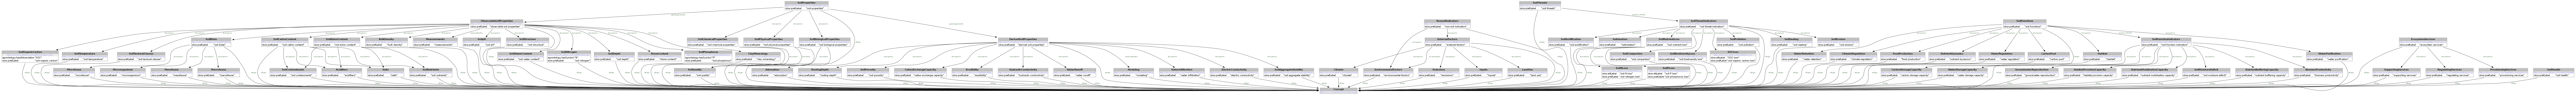

In [19]:
# Visualize the graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

### Post-process the knowledge graph

In [55]:
# Load the JSON dataset
with open('benchmarks/text_RDF_gs.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Access the dataset
dataset = data['dataset']

In [56]:
def parse_turtle(turtle_string):
    g = Graph()
    g.parse(data=turtle_string, format='turtle')
    return g

def merge_graphs(json_data):
    merged_graph = Graph()
    
    for item in json_data['dataset']:
        turtle_string = item['rdf_graph_turtle']
        graph = parse_turtle(turtle_string)
        merged_graph += graph
    
    return merged_graph

def remove_duplicates(graph):
    # Create a new graph to store unique triples
    unique_graph = Graph()
    
    # Iterate through all triples in the original graph
    for s, p, o in graph:
        # Check if the triple already exists in the unique graph
        if not (s, p, o) in unique_graph:
            unique_graph.add((s, p, o))
    
    return unique_graph

def main(file_path):
    merged_graph = merge_graphs(data)
    unique_graph = remove_duplicates(merged_graph)

    unique_graph.bind("agrontology", agrontology)
    unique_graph.bind("qudt", qudt)
    unique_graph.bind("she", she)
    unique_graph.bind("unit", unit)
    unique_graph.bind("sio", sio)
    unique_graph.bind("obo", obo)
    unique_graph.bind("wdt", wdt)
    unique_graph.bind("biolink", biolink)
    unique_graph.bind("af-x", afox)
    unique_graph.bind("af-r", afor)
    unique_graph.bind("sorelpr", sorelpr)
    unique_graph.bind("sorelsc", sorelsc)
    unique_graph.bind("sohuj", sohuj)
    unique_graph.bind("sorelph", sorelph)
    unique_graph.bind("sorelm", sorelm)
    unique_graph.bind("bao", bao)
    unique_graph.bind("repr", repr)
    unique_graph.bind("sorepsg", sorepsg)
    unique_graph.bind("sorelch", sorelch)
    unique_graph.bind("sorelsp", sorelsp)
    unique_graph.bind("om", om)
    unique_graph.bind("af-p", afop)

    return unique_graph

if __name__ == "__main__":
    unique_graph = main("text_RDF_gs.json")

In [51]:
def add_inverse_triples(graph, csv_file_path):
    # Load invertible properties from CSV file
    invertible_properties = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            if len(row) == 2:
                prop, inverse = row
                prop = prop.strip()
                inverse = inverse.strip()
                invertible_properties[prop] = inverse
                invertible_properties[inverse] = prop  # Add bidirectional mapping

    # Add triples with inverted properties
    new_triples = []

    for s, p, o in graph:
        property_uri = str(p)
        # Check if this property is in our invertible set
        if property_uri in invertible_properties:
            # Skip triples where subject or object is a BNode, or object is a literal
            if isinstance(s, rdflib.BNode) or isinstance(o, rdflib.BNode) or isinstance(o, rdflib.Literal):
                continue

            # Otherwise, add inverse triple
            inverse_property_uri = invertible_properties[property_uri]
            inverse_property = rdflib.URIRef(inverse_property_uri)
            new_triples.append((o, inverse_property, s))

    # Add the new triples to the graph
    for subj, pred, obj in new_triples:
        graph.add((subj, pred, obj))

    return graph

unique_graph = add_inverse_triples(unique_graph, 'in_ontovocabs/prop_mapping.csv')

In [150]:
# Function to normalize British English to American English
def normalize_uk_to_us(label):
    for uk_spelling, us_spelling in uk_us:
        # Use regular expressions to replace only full words
        label = re.sub(rf'\b{uk_spelling}\b', us_spelling, label)
    return label

def concept2vocabs(g, file_path):
    # Load the CSV file
    pref_label_map = {}
    alt_label_map = {}
    with open(file_path, encoding="utf8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            new_uri = row['concept']
            pref_label = row['prefLabel'].lower()
            alt_labels = row['altLabels'].split(';') if row['altLabels'] else []
            pref_label_map[pref_label] = new_uri
            for alt_label in alt_labels:
                alt_label = alt_label.strip().lower()  # Clean and normalize altLabel
                if alt_label:
                    alt_label_map[alt_label] = new_uri

    # Iterate over the graph and process matching prefLabel and altLabel
    for s, p, o in g:
        label = str(o).lower()
        normalized_label = normalize_uk_to_us(label)  # Apply normalization

        if p == SKOS.prefLabel and normalized_label in pref_label_map:
            # Add skos:exactMatch triples
            exact_match_uri = rdflib.URIRef(pref_label_map[normalized_label])
            g.add((s, SKOS.exactMatch, exact_match_uri))
        elif p == SKOS.prefLabel and normalized_label in alt_label_map:
            # Add skos:closeMatch triples
            close_match_uri = rdflib.URIRef(alt_label_map[normalized_label])
            g.add((s, SKOS.closeMatch, close_match_uri))

    return g

In [ ]:
# Link to AGROVOC vocabs
unique_graph = concept2vocabs(unique_graph, "ex_ontovocabs/agrovoc.csv")
unique_graph.bind("agrovoc", agrovoc)

In [ ]:
# Link to ISO11074
unique_graph = concept2vocabs(unique_graph, "ex_ontovocabs/ISO11074v2025.csv")
unique_graph.bind("iso11074", iso11074)

In [152]:
# Link to INRAE Thesaurus
unique_graph = concept2vocabs(unique_graph, "ex_ontovocabs/inrae.csv")
unique_graph.bind("inrae", inrae)

In [153]:
# Link to GEMET Thesaurus
unique_graph = concept2vocabs(unique_graph, "ex_ontovocabs/gemet.csv")
unique_graph.bind("gemet", gemet)

In [128]:
for subj, pred, obj in unique_graph:
    if isinstance(obj, rdflib.Literal):
        # Check if the literal is a pure number or already has a datatype
        if obj.datatype is None and not re.match(r'^\d+$', str(obj)):
            # Add language tag to string literals (except pure numbers and typed literals)
            new_obj = rdflib.Literal(obj, lang='en')
            unique_graph.add((subj, pred, new_obj))
            unique_graph.remove((subj, pred, obj))

In [155]:
# Serialize the final graph to Turtle format
unique_graph.serialize(destination="soil_health_KG.ttl", format="turtle")

<Graph identifier=N6a1008de1adb4c518912d0b8bc0d1cee (<class 'rdflib.graph.Graph'>)>

In [15]:
unique_graph = Graph()
unique_graph.parse("soil_health_KG.ttl", format="turtle")

<Graph identifier=N24a50052c05f48319739783a2d85767b (<class 'rdflib.graph.Graph'>)>

#### Singular labels

In [47]:
def add_singular_forms_as_altlabels(graph_file, output_file=None):
    # Ensure the required NLTK data is downloaded
    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    
    # Load the RDF graph
    g = Graph()
    g.parse(graph_file)
    
    # Keep track of new triples to add
    new_triples = []
    
    # Find all skos:prefLabel triples
    for s, pred, o in g.triples((None, SKOS.prefLabel, None)):
        # Get the label text
        pref_label = str(o)
        
        # Tokenize and POS tag the label
        tokens = word_tokenize(pref_label)
        tagged_tokens = pos_tag(tokens)
        
        # Process each token
        singular_tokens = []
        for word, tag in tagged_tokens:
            # Check if the word is a plural noun (NNS for plural noun)
            if tag == 'NNS':
                # Get the singular form
                singular_forms = lemminflect.getLemma(word, 'NOUN')
                if singular_forms:
                    singular_tokens.append(singular_forms[0])
                else:
                    singular_tokens.append(word)
            else:
                singular_tokens.append(word)
        
        # Join the tokens back into a phrase
        singular_form = ' '.join(singular_tokens)
        
        # Only add if different from original
        if singular_form != pref_label:
            new_triples.append((s, SKOS.altLabel, Literal(singular_form, lang=o.language if hasattr(o, 'language') else None)))
    
    # Add all new triples to the graph
    for triple in new_triples:
        g.add(triple)
    
    # Save the modified graph
    if output_file:
        g.serialize(destination=output_file, format="turtle")
    
    return g

if __name__ == "__main__":
    graph_file = "soil_health_KG.ttl"
    output_file = "soil_health_KG.ttl"
    
    modified_graph = add_singular_forms_as_altlabels(graph_file, output_file)
    print(f"Successfully added singular forms as altLabels to {output_file}")

Successfully added singular forms as altLabels to soil_health_KG.ttl


#### Ontology in Turtle

In [ ]:
def csv_to_ttl_ontology(classes_file, properties_file, prop_mapping_file, output_file):
    """
    Convert CSV files containing ontology information into a TTL ontology file.
    
    Args:
        classes_file: Path to classes CSV file
        properties_file: Path to properties CSV file  
        prop_mapping_file: Path to property mapping CSV file
        output_file: Path for output TTL file
    """
    
    # Read CSV files
    classes_df = pd.read_csv(classes_file)
    properties_df = pd.read_csv(properties_file)
    prop_mapping_df = pd.read_csv(prop_mapping_file)
    
    # Clean headers (strip whitespace)
    classes_df.columns = classes_df.columns.str.strip()
    properties_df.columns = properties_df.columns.str.strip()
    prop_mapping_df.columns = prop_mapping_df.columns.str.strip()
    
    # Extract namespace prefixes from the data
    prefixes = set()
    
    def extract_prefix(turtle_notation):
        """Extract prefix from turtle notation (e.g., 'skos:Concept' -> 'skos')"""
        if ':' in str(turtle_notation):
            return str(turtle_notation).split(':')[0]
        return None
    
    def get_namespace_from_uri(uri):
        """Extract namespace from full URI"""
        if '#' in uri:
            return uri.split('#')[0] + '#'
        else:
            # For URIs ending with /, take everything up to the last /
            parts = uri.rstrip('/').split('/')
            return '/'.join(parts[:-1]) + '/'
    
    # Collect prefixes and their namespaces
    prefix_to_namespace = {}
    
    # From classes
    for _, row in classes_df.iterrows():
        prefix = extract_prefix(row['class'])
        if prefix:
            namespace = get_namespace_from_uri(row['uri'])
            prefix_to_namespace[prefix] = namespace
    
    # From properties  
    for _, row in properties_df.iterrows():
        prefix = extract_prefix(row['prop'])
        if prefix:
            namespace = get_namespace_from_uri(row['uri'])
            prefix_to_namespace[prefix] = namespace
    
    # Create inverse property mapping for quick lookup
    inverse_map = {}
    for _, row in prop_mapping_df.iterrows():
        prop_uri = str(row['prop']).strip()
        inverse_uri = str(row['inverse']).strip()
        inverse_map[prop_uri] = inverse_uri
        # Add reverse mapping as well
        inverse_map[inverse_uri] = prop_uri
    
    # Start building TTL content
    ttl_content = []
    
    # Add standard prefixes
    ttl_content.extend([
        "@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .",
        "@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .",
        "@prefix owl: <http://www.w3.org/2002/07/owl#> .",
        "@prefix skos: <http://www.w3.org/2004/02/skos/core#> .",
    ])
    
    # Add discovered prefixes
    for prefix, namespace in sorted(prefix_to_namespace.items()):
        if prefix not in ['rdf', 'rdfs', 'owl', 'skos']:  # Skip standard prefixes
            ttl_content.append(f"@prefix {prefix}: <{namespace}> .")
    
    ttl_content.append("")  # Empty line after prefixes
    
    # Add classes
    ttl_content.append("# Classes")
    for _, row in classes_df.iterrows():
        class_turtle = str(row['class']).strip()
        label = str(row['label']).strip()
        
        ttl_content.extend([
            f"{class_turtle} a rdfs:Class ;",
            f"    skos:prefLabel \"{label}\" .",
            ""
        ])
    
    # Add properties
    ttl_content.append("# Properties")
    for _, row in properties_df.iterrows():
        prop_turtle = str(row['prop']).strip()
        prop_uri = str(row['uri']).strip()
        label = str(row['label']).strip()
        
        ttl_lines = [
            f"{prop_turtle} a rdf:Property ;",
            f"    skos:prefLabel \"{label}\" ;"
        ]
        
        # Check if this property has an inverse
        if prop_uri in inverse_map:
            inverse_uri = inverse_map[prop_uri]
            # Find the turtle notation for the inverse property
            inverse_turtle = None
            for _, inv_row in properties_df.iterrows():
                if str(inv_row['uri']).strip() == inverse_uri:
                    inverse_turtle = str(inv_row['prop']).strip()
                    break
            
            if inverse_turtle:
                ttl_lines.append(f"    owl:inverseOf {inverse_turtle}")
        
        # Close the property definition
        ttl_lines[-1] += " ."
        ttl_content.extend(ttl_lines)
        ttl_content.append("")
    
    # Write to file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(ttl_content))
    
    print(f"Ontology TTL file created successfully: {output_file}")
    print(f"Classes processed: {len(classes_df)}")
    print(f"Properties processed: {len(properties_df)}")
    print(f"Inverse property pairs: {len(prop_mapping_df)}")

# Usage example
if __name__ == "__main__":
    csv_to_ttl_ontology(
        classes_file="in_ontovocabs/classes.csv",
        properties_file="in_ontovocabs/properties.csv", 
        prop_mapping_file="in_ontovocabs/prop_mapping.csv",
        output_file="in_ontovocabs/ontology.ttl"
    )

Ontology TTL file created successfully: in_ontovocabs/ontology.ttl
Classes processed: 20
Properties processed: 205
Inverse property pairs: 60


#### Entity normalization

In [129]:
def get_labels(graph, entity):
    """
    Retrieve all labels (prefLabel and altLabel) for a given entity.
    """
    labels = []
    # Get preferred labels
    for label in graph.objects(entity, SKOS.prefLabel):
        labels.append(str(label))
    # Get alternative labels if any
    for label in graph.objects(entity, SKOS.altLabel):
        labels.append(str(label))
    return labels

def embed_text(text, model="text-embedding-3-large"):
    """
    Get an embedding for the given text using OpenAI's embedding API.
    """
    response = client.embeddings.create(input=[text], model=model)
    embedding = response.data[0].embedding
    return np.array(embedding)

def cosine_similarity(emb1, emb2):
    """
    Compute cosine similarity between two embeddings.
    """
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

def main():
    # Load the RDF graph from the Turtle file
    graph = rdflib.Graph()
    ttl_file = "soil_health_KG.ttl"  # update with your filename
    graph.parse(ttl_file, format="turtle")

    # Get all entities that have at least one skos:prefLabel
    entities = set(graph.subjects(SKOS.prefLabel, None))
    entity_data = {}

    # For each entity, embed each label separately.
    for entity in entities:
        labels = get_labels(graph, entity)
        if not labels:
            continue  # skip if no label is found
        embeddings = []
        for label in labels:
            # Uncomment the next line to see progress for each label.
            print(f"Embedding label for {entity}: {label}")
            embedding = embed_text(label)
            embeddings.append(embedding)
        entity_data[entity] = {"labels": labels, "embeddings": embeddings}

    # Calculate the maximum cosine similarity between every pair of entity embeddings.
    similar_pairs = []
    for (ent1, data1), (ent2, data2) in itertools.combinations(entity_data.items(), 2):
        max_sim = -1.0  # initialize to -1 so any similarity replaces it
        for emb1 in data1["embeddings"]:
            for emb2 in data2["embeddings"]:
                sim = cosine_similarity(emb1, emb2)
                if sim > max_sim:
                    max_sim = sim
        similar_pairs.append((max_sim, ent1, ent2))

    # Sort the pairs by similarity in descending order
    similar_pairs.sort(key=lambda x: x[0], reverse=True)

    # Write the similarity results to a CSV file
    csv_filename = "entity_similarity.csv"
    with open(csv_filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["entity1", "entity2", "similarity"])
        for sim, ent1, ent2 in similar_pairs:
            writer.writerow([str(ent1), str(ent2), sim])

    print(f"Similarity results have been stored in {csv_filename}")

if __name__ == "__main__":
    main()

Embedding label for https://soilwise-he.github.io/soil-health#Precipitation: precipitation
Embedding label for https://soilwise-he.github.io/soil-health#SoilMicrobialActivity: soil microbial activity
Embedding label for https://soilwise-he.github.io/soil-health#Trichloroethane: 1,1,1-trichloroethane
Embedding label for https://soilwise-he.github.io/soil-health#HighSoilPStatus: high soil P status
Embedding label for https://soilwise-he.github.io/soil-health#SheetwashErosion: sheetwash erosion
Embedding label for https://soilwise-he.github.io/soil-health#SpeciesDiversity: species diversity
Embedding label for https://soilwise-he.github.io/soil-health#UrbanSprawl: urban sprawl
Embedding label for https://soilwise-he.github.io/soil-health#FoodQualityStandard: food quality standard
Embedding label for https://soilwise-he.github.io/soil-health#IntegratedManagementApproaches: integrated management approaches
Embedding label for https://soilwise-he.github.io/soil-health#CriticalConcentrations:

In [130]:
def cluster_entities(csv_filename, threshold):
    """
    Build an undirected graph from the CSV file and cluster entities
    based on the similarity threshold. An edge is added between two entities
    if their similarity is greater than the threshold.
    """
    G = nx.Graph()
    with open(csv_filename, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            ent1 = row['entity1']
            ent2 = row['entity2']
            similarity = float(row['similarity'])
            if similarity > threshold:
                G.add_edge(ent1, ent2, weight=similarity)
    # Clusters are the connected components of the graph.
    clusters = list(nx.connected_components(G))
    return clusters

def main():
    csv_filename = "entity_similarity.csv"  # The CSV file from previous code
    threshold = 0.8
    clusters = cluster_entities(csv_filename, threshold)
    
    print("Entity Clusters:")
    for idx, cluster in enumerate(clusters):
        print(f"Cluster {idx+1}: {cluster}")

if __name__ == "__main__":
    main()

Entity Clusters:
Cluster 1: {'https://soilwise-he.github.io/soil-health#OrganicCompounds', 'https://soilwise-he.github.io/soil-health#SelectedOrganicCompounds'}
Cluster 2: {'https://soilwise-he.github.io/soil-health#HeavyMetals', 'https://soilwise-he.github.io/soil-health#MonitoredHeavyMetals'}
Cluster 3: {'https://soilwise-he.github.io/soil-health#MonitoredNutrients', 'https://soilwise-he.github.io/soil-health#Nutrients'}
Cluster 4: {'https://soilwise-he.github.io/soil-health#SoilLossRates', 'https://soilwise-he.github.io/soil-health#TolerableSoilLoss', 'https://soilwise-he.github.io/soil-health#SoilLoss', 'https://soilwise-he.github.io/soil-health#ActualSoilErosionRate', 'https://soilwise-he.github.io/soil-health#SoilErosionRateAcceleration', 'https://soilwise-he.github.io/soil-health#AnnualSoilLoss', 'https://soilwise-he.github.io/soil-health#SoilLossRatesByWater', 'https://soilwise-he.github.io/soil-health#TolerableSoilLossRates', 'https://soilwise-he.github.io/soil-health#SoilEros

In [69]:
def check_labels_in_rdf(file_path):
    """
    Check if all entities except references (dcterms:BibliographicResource) have 
    at least one skos:prefLabel, and if any entity has more than one skos:prefLabel.
    
    Args:
        file_path: Path to the Turtle (.ttl) file
    """
    # Initialize graph
    g = Graph()
    
    # Parse the Turtle file
    print(f"Parsing {file_path}...")
    g.parse(file_path, format="turtle")
    print(f"Parsed {len(g)} triples.")
    
    # Define relevant namespaces and predicates
    skos_prefLabel = SKOS.prefLabel
    dcterms_BibliographicResource = DCTERMS.BibliographicResource
    
    # Get all entities (subjects with an RDF.type predicate)
    all_entities = set()
    for s, p, o in g.triples((None, RDF.type, None)):
        # We're only interested in URIs and blank nodes as entities, not literals
        if isinstance(s, (URIRef, BNode)):
            all_entities.add(s)
    
    # Identify references (entities of type dcterms:BibliographicResource)
    references = set()
    for s, p, o in g.triples((None, RDF.type, dcterms_BibliographicResource)):
        references.add(s)
    
    # Non-reference entities
    non_references = all_entities - references
    
    # Check if all non-references have at least one skos:prefLabel
    entities_without_label = set()
    for entity in non_references:
        labels = list(g.objects(entity, skos_prefLabel))
        if not labels:
            entities_without_label.add(entity)
    
    # Check if any entity has more than one skos:prefLabel
    entities_with_multiple_labels = []
    for entity in all_entities:
        labels = list(g.objects(entity, skos_prefLabel))
        if len(labels) > 1:
            entities_with_multiple_labels.append((entity, labels))
    
    # Print summary
    print("\n=== Summary ===")
    print(f"Total entities: {len(all_entities)}")
    print(f"References (dcterms:BibliographicResource): {len(references)}")
    print(f"Non-references: {len(non_references)}")
    print(f"Non-reference entities without skos:prefLabel: {len(entities_without_label)}")
    print(f"Entities with multiple skos:prefLabel values: {len(entities_with_multiple_labels)}")
    
    # Print details about entities without labels
    print("\n=== Entities without skos:prefLabel ===")
    if entities_without_label:
        for i, entity in enumerate(entities_without_label, 1):
            # Get the types of this entity
            types = [str(o) for o in g.objects(entity, RDF.type)]
            print(f"  {i}. {entity}")
            print(f"     Types: {', '.join(types)}")
    else:
        print("All non-reference entities have at least one skos:prefLabel.")
    
    # Print details about entities with multiple labels
    print("\n=== Entities with multiple skos:prefLabel values ===")
    if entities_with_multiple_labels:
        for i, (entity, labels) in enumerate(entities_with_multiple_labels, 1):
            # Get the types of this entity
            types = [str(o) for o in g.objects(entity, RDF.type)]
            is_reference = entity in references
            
            print(f"  {i}. {entity}")
            print(f"     Types: {', '.join(types)}")
            print(f"     Is reference: {is_reference}")
            print(f"     Labels ({len(labels)}):")
            for j, label in enumerate(labels, 1):
                if isinstance(label, Literal):
                    lang = f"@{label.language}" if label.language else ""
                    print(f"       {j}. \"{label}\"{lang}")
                else:
                    print(f"       {j}. {label}")
    else:
        print("No entities with multiple skos:prefLabel values found.")

# Set your file path here
file_path = "soil_health_KG.ttl"  # CHANGE THIS TO YOUR FILE PATH

# Run the script
if __name__ == "__main__":
    check_labels_in_rdf(file_path)

Parsing soil_health_KG.ttl...
Parsed 10996 triples.

=== Summary ===
Total entities: 2023
References (dcterms:BibliographicResource): 158
Non-references: 1865
Non-reference entities without skos:prefLabel: 7
Entities with multiple skos:prefLabel values: 0

=== Entities without skos:prefLabel ===
  1. https://soilwise-he.github.io/soil-health#CO2
     Types: http://www.w3.org/2004/02/skos/core#Concept
  2. https://soilwise-he.github.io/soil-health#BTEX
     Types: http://www.w3.org/2004/02/skos/core#Concept
  3. https://soilwise-he.github.io/soil-health#PCDF
     Types: http://www.w3.org/2004/02/skos/core#Concept
  4. https://soilwise-he.github.io/soil-health#PAHs
     Types: http://www.w3.org/2004/02/skos/core#Concept
  5. https://soilwise-he.github.io/soil-health#DDT
     Types: http://www.w3.org/2004/02/skos/core#Concept
  6. https://soilwise-he.github.io/soil-health#PFAS
     Types: http://www.w3.org/2004/02/skos/core#Concept
  7. https://soilwise-he.github.io/soil-health#PCDD
     

#### Relation disambiguation

In [102]:
def load_rdf_file(file_path):
    """Load an RDF file into a graph."""
    g = Graph()
    
    try:
        g.parse(file_path)
        print(f"Successfully loaded {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    
    return g

def extract_skos_hierarchy(g):
    """Extract SKOS hierarchical relationships into a directed graph.
    
    In the resulting graph:
    - An edge from A to B means A is broader than B (or B is narrower than A)
    """
    # Create a directed graph where edge A->B means A is broader than B
    G = nx.DiGraph()
    
    # Extract all skos:broader relationships
    # If A skos:broader B, then B is broader than A (edge B->A)
    for s, p, o in g.triples((None, SKOS.broader, None)):
        G.add_edge(str(o), str(s))  # o is broader than s
    
    # Extract all skos:narrower relationships
    # If A skos:narrower B, then A is broader than B (edge A->B)
    for s, p, o in g.triples((None, SKOS.narrower, None)):
        G.add_edge(str(s), str(o))  # s is broader than o
    
    return G

def detect_transitive_inconsistencies(G):
    """Detect inconsistencies where a concept has multiple paths to another concept."""
    inconsistencies = []
    
    # For each node in the graph
    for node in G.nodes():
        # Get direct children
        direct_children = list(G.successors(node))
        
        # For each direct child
        for child in direct_children:
            # Check if any other direct child is an ancestor of this child
            for other_child in direct_children:
                if other_child != child and nx.has_path(G, other_child, child):
                    # Found inconsistency: node -> child and node -> other_child -> ... -> child
                    inconsistencies.append({
                        'type': 'transitive_inconsistency',
                        'node': node,
                        'direct_child': child,
                        'mediating_child': other_child,
                        'description': f"{node} has direct relationship to {child}, "
                                      f"but this should be mediated through {other_child}"
                    })
    
    return inconsistencies

def detect_cycle_inconsistencies(G):
    """Detect cycles in the hierarchy, which represent contradictory relationships."""
    cycle_inconsistencies = []
    
    try:
        cycles = list(nx.simple_cycles(G))
        for cycle in cycles:
            cycle_inconsistencies.append({
                'type': 'cycle_inconsistency',
                'nodes': cycle,
                'description': f"Cycle detected: {' -> '.join(cycle)} -> {cycle[0]}"
            })
    except nx.NetworkXNoCycle:
        # No cycles found
        pass
    
    return cycle_inconsistencies

def detect_multiple_broader_concepts(G):
    """Detect cases where a concept has multiple broader concepts 
    that aren't in a hierarchical relationship with each other."""
    inconsistencies = []
    
    # For each node in the graph
    for node in G.nodes():
        # Get direct broader concepts (predecessors)
        broader_concepts = list(G.predecessors(node))
        
        # If there are multiple broader concepts
        if len(broader_concepts) > 1:
            unrelated_pairs = []
            
            # Check each pair of broader concepts
            for i in range(len(broader_concepts)):
                for j in range(i+1, len(broader_concepts)):
                    concept1 = broader_concepts[i]
                    concept2 = broader_concepts[j]
                    
                    # Check if there's no hierarchical relationship between them
                    if (not nx.has_path(G, concept1, concept2) and 
                        not nx.has_path(G, concept2, concept1)):
                        unrelated_pairs.append((concept1, concept2))
            
            if unrelated_pairs:
                inconsistencies.append({
                    'type': 'multiple_broader_concepts',
                    'node': node,
                    'broader_concepts': broader_concepts,
                    'unrelated_pairs': unrelated_pairs,
                    'description': f"{node} has multiple unrelated broader concepts: {', '.join(broader_concepts)}"
                })
    
    return inconsistencies

def suggest_corrections(inconsistencies):
    """Suggest corrections for the detected inconsistencies."""
    corrections = []
    
    for inconsistency in inconsistencies:
        if inconsistency['type'] == 'transitive_inconsistency':
            node = inconsistency['node']
            direct_child = inconsistency['direct_child']
            mediating_child = inconsistency['mediating_child']
            
            # Find the shortest path through the mediating child
            correction = {
                'type': 'remove_direct_relationship',
                'from': node,
                'to': direct_child,
                'description': f"Remove direct relationship: {node} skos:narrower {direct_child}. "
                               f"The relationship is already established through: "
                               f"{node} skos:narrower {mediating_child} ... skos:narrower {direct_child}"
            }
            corrections.append(correction)
        
        elif inconsistency['type'] == 'cycle_inconsistency':
            nodes = inconsistency['nodes']
            
            correction = {
                'type': 'resolve_cycle',
                'nodes': nodes,
                'description': f"Resolve cycle by removing one of the relationships in: {' -> '.join(nodes)} -> {nodes[0]}. "
                               f"Review and determine the correct hierarchical structure."
            }
            corrections.append(correction)
        
        elif inconsistency['type'] == 'multiple_broader_concepts':
            node = inconsistency['node']
            broader_concepts = inconsistency['broader_concepts']
            unrelated_pairs = inconsistency['unrelated_pairs']
            
            correction = {
                'type': 'review_multiple_parents',
                'node': node,
                'broader_concepts': broader_concepts,
                'description': f"Review the multiple broader concepts for {node}: {', '.join(broader_concepts)}. "
                               f"Determine if these should be related in a hierarchy or if one relationship should be removed."
            }
            corrections.append(correction)
    
    return corrections

def format_results(results):
    """Format the results for display."""
    output = []
    
    # Count inconsistencies
    total_inconsistencies = len(results['inconsistencies']['all'])
    output.append(f"SKOS Relationship Inconsistency Report")
    output.append(f"======================================")
    output.append(f"\nFound {total_inconsistencies} inconsistencies in total:")
    output.append(f"- {len(results['inconsistencies']['transitive'])} transitive inconsistencies")
    output.append(f"- {len(results['inconsistencies']['cycles'])} cycle inconsistencies")
    output.append(f"- {len(results['inconsistencies']['multiple_broader'])} multiple broader concept inconsistencies")
    
    # Print each inconsistency with its suggested correction
    for i, inconsistency in enumerate(results['inconsistencies']['all']):
        output.append(f"\n--- Inconsistency {i+1} ---")
        output.append(f"Type: {inconsistency['type']}")
        output.append(f"Description: {inconsistency['description']}")
        
        # Find matching correction
        for correction in results['corrections']:
            if (('node' in inconsistency and 'from' in correction and inconsistency['node'] == correction['from']) or
                ('nodes' in inconsistency and 'nodes' in correction and inconsistency['nodes'] == correction['nodes'])):
                output.append(f"Suggested correction: {correction['description']}")
                break
    
    return "\n".join(output)

def main(file_path):
    """Main function to run the inconsistency detection and correction suggestion."""
    # Step 1: Load RDF file
    g = load_rdf_file(file_path)
    
    # Step 2: Extract SKOS hierarchy into a directed graph
    G = extract_skos_hierarchy(g)
    
    # Count nodes and edges
    print(f"Extracted graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Step 3: Detect inconsistencies
    transitive_inconsistencies = detect_transitive_inconsistencies(G)
    cycle_inconsistencies = detect_cycle_inconsistencies(G)
    multiple_broader_inconsistencies = detect_multiple_broader_concepts(G)
    
    all_inconsistencies = (transitive_inconsistencies + 
                          cycle_inconsistencies + 
                          multiple_broader_inconsistencies)
    
    # Step 4: Suggest corrections
    corrections = suggest_corrections(all_inconsistencies)
    
    # Print results
    results = {
        'inconsistencies': {
            'transitive': transitive_inconsistencies,
            'cycles': cycle_inconsistencies,
            'multiple_broader': multiple_broader_inconsistencies,
            'all': all_inconsistencies
        },
        'corrections': corrections
    }
    
    print(format_results(results))
    
    return {
        'graph': G,
        'inconsistencies': results['inconsistencies'],
        'corrections': corrections
    }

if __name__ == "__main__":
    # Example usage with a single merged knowledge graph file
    file_path = "soil_health_KG.ttl"  # Replace with your actual file path
    
    results = main(file_path)

Successfully loaded soil_health_KG.ttl
Extracted graph has 596 nodes and 593 edges
SKOS Relationship Inconsistency Report

Found 78 inconsistencies in total:
- 11 transitive inconsistencies
- 0 cycle inconsistencies
- 67 multiple broader concept inconsistencies

--- Inconsistency 1 ---
Type: transitive_inconsistency
Description: https://soilwise-he.github.io/soil-health#ObservableSoilProperties has direct relationship to https://soilwise-he.github.io/soil-health#SoilNitrogen, but this should be mediated through https://soilwise-he.github.io/soil-health#SoilAnionContent
Suggested correction: Remove direct relationship: https://soilwise-he.github.io/soil-health#ObservableSoilProperties skos:narrower https://soilwise-he.github.io/soil-health#SoilNitrogen. The relationship is already established through: https://soilwise-he.github.io/soil-health#ObservableSoilProperties skos:narrower https://soilwise-he.github.io/soil-health#SoilAnionContent ... skos:narrower https://soilwise-he.github.io/

In [34]:
def extract_skos_subgraph(rdf_graph):
    """Extract a subgraph containing only SKOS relationships."""
    skos_subgraph = Graph()
    for s, p, o in rdf_graph:
        if p in [SKOS.narrower, SKOS.broader, SKOS.related]:
            skos_subgraph.add((s, p, o))
    return skos_subgraph

def build_hierarchy_graph(skos_subgraph):
    """
    Build a directed graph representing hierarchical relationships.
    Direction: if A -> B, then A is broader than B (B is narrower than A).
    """
    hierarchy_graph = nx.DiGraph()
    
    # Add all concepts as nodes first to ensure isolated nodes are included
    for s, _, o in skos_subgraph:
        hierarchy_graph.add_node(s)
        hierarchy_graph.add_node(o)
    
    # Add edges for hierarchical relationships
    for s, p, o in skos_subgraph:
        if p == SKOS.narrower:
            hierarchy_graph.add_edge(s, o)  # s is broader than o
        elif p == SKOS.broader:
            hierarchy_graph.add_edge(o, s)  # o is broader than s
    
    return hierarchy_graph

def collect_related_pairs(skos_subgraph):
    """Collect all pairs of concepts that are marked as related."""
    related_pairs = set()
    for s, p, o in skos_subgraph:
        if p == SKOS.related:
            related_pairs.add((s, o))
    return related_pairs

def find_hierarchical_path(hierarchy_graph, concept_a, concept_b):
    """Find a path in the hierarchy from concept_a to concept_b if one exists."""
    try:
        if nx.has_path(hierarchy_graph, concept_a, concept_b):
            return nx.shortest_path(hierarchy_graph, concept_a, concept_b)
    except nx.NetworkXError:
        # Handle case where nodes aren't in the graph
        pass
    return None

def collect_path_triples(skos_subgraph, path):
    """Collect the SKOS triples that form a given path."""
    path_triples = []
    for i in range(len(path) - 1):
        source, target = path[i], path[i+1]
        for s, p, o in skos_subgraph:
            if (p == SKOS.narrower and s == source and o == target) or \
               (p == SKOS.broader and s == target and o == source):
                path_triples.append((s, p, o))
                break
    return path_triples

def detect_skos_inconsistencies(rdf_file_path, format=None):
    """
    Detect inconsistencies in SKOS relationships in an RDF knowledge graph.
    
    Args:
        rdf_file_path: Path to the RDF file containing the integrated knowledge graph.
        format: Format of the RDF file (e.g., 'turtle', 'xml', 'n3'). If None, rdflib will try to guess.
    
    Returns:
        A list of inconsistency reports.
    """
    # Load the RDF graph
    rdf_graph = Graph()
    rdf_graph.parse(rdf_file_path, format=format)
    
    # Extract the SKOS subgraph
    skos_subgraph = extract_skos_subgraph(rdf_graph)
    
    # Build the hierarchy graph
    hierarchy_graph = build_hierarchy_graph(skos_subgraph)
    
    # Collect all related pairs
    related_pairs = collect_related_pairs(skos_subgraph)
    
    # Find inconsistencies
    inconsistencies = []
    
    for a, c in related_pairs:
        if a == c:  # Skip self-relations
            continue
        
        # Check for path from a to c (a is broader than c)
        path_a_to_c = find_hierarchical_path(hierarchy_graph, a, c)
        if path_a_to_c:
            path_triples = collect_path_triples(skos_subgraph, path_a_to_c)
            inconsistencies.append({
                "related_pair": (a, c),
                "path": path_a_to_c,
                "direction": "broader",
                "path_triples": path_triples
            })
            continue
        
        # Check for path from c to a (c is broader than a)
        path_c_to_a = find_hierarchical_path(hierarchy_graph, c, a)
        if path_c_to_a:
            path_triples = collect_path_triples(skos_subgraph, path_c_to_a)
            inconsistencies.append({
                "related_pair": (a, c),
                "path": path_c_to_a,
                "direction": "narrower",
                "path_triples": path_triples
            })
    
    # Format the inconsistencies for readability
    formatted_reports = []
    
    for inconsistency in inconsistencies:
        a, c = inconsistency["related_pair"]
        path = inconsistency["path"]
        direction = inconsistency["direction"]
        path_triples = inconsistency["path_triples"]
        
        path_str = " -> ".join(str(node) for node in path)
        triples_str = "\n  ".join(f"{s} {p} {o}" for s, p, o in path_triples)
        
        if direction == "broader":
            formatted_report = (
                f"Inconsistency: {a} and {c} are marked as 'related', but {a} is broader than {c} via path:\n"
                f"  {path_str}\n"
                f"Based on triples:\n  {triples_str}"
            )
        else:  # direction == "narrower"
            formatted_report = (
                f"Inconsistency: {a} and {c} are marked as 'related', but {a} is narrower than {c} via path:\n"
                f"  {path_str}\n"
                f"Based on triples:\n  {triples_str}"
            )
        
        formatted_reports.append(formatted_report)
    
    return formatted_reports

def print_inconsistency_report(inconsistencies, output_file=None):
    """
    Print inconsistencies to console or save to a file.
    
    Args:
        inconsistencies: List of inconsistency reports
        output_file: Optional file path to save the report
    """
    if not inconsistencies:
        print("No inconsistencies found.")
        if output_file:
            with open(output_file, 'w') as f:
                f.write("No inconsistencies found.\n")
        return
    
    print(f"Found {len(inconsistencies)} inconsistencies:")
    
    if output_file:
        with open(output_file, 'w') as f:
            f.write(f"Found {len(inconsistencies)} inconsistencies:\n")
            for i, report in enumerate(inconsistencies, 1):
                f.write(f"\nInconsistency {i}:\n")
                f.write(report + "\n")
        print(f"Report saved to {output_file}")
    else:
        for i, report in enumerate(inconsistencies, 1):
            print(f"\nInconsistency {i}:")
            print(report)

# ----------------------------------------------------------------------
# CONFIGURATION SECTION - MODIFY THESE VARIABLES TO MATCH YOUR SETUP
# ----------------------------------------------------------------------

# Path to your RDF file
INPUT_FILE = "soil_health_KG.ttl"

# Format of the RDF file (e.g., 'turtle', 'xml', 'n3') - set to None to auto-detect
FILE_FORMAT = None

# Path to save the inconsistency report (set to None to print to console only)
OUTPUT_FILE = None  # or "inconsistencies.txt" to save to a file

# ----------------------------------------------------------------------
# EXAMPLE CODE: To analyze a specific RDF file
# ----------------------------------------------------------------------

# Example with a string literal RDF content for testing purposes
def create_test_graph():
    """Create a test graph with inconsistent SKOS relationships"""
    
    # Create a new graph
    g = Graph()
    
    # Define namespaces
    SHE = Namespace("https://soilwise-he.github.io/soil-health#")
    
    # Add triples with inconsistent relationships
    g.add((SHE.ConceptA, SKOS.narrower, SHE.ConceptB))
    g.add((SHE.ConceptA, SKOS.related, SHE.ConceptC))
    g.add((SHE.ConceptB, SKOS.narrower, SHE.ConceptC))
    
    # Save test graph to a file
    test_file = "test_skos_graph.ttl"
    g.serialize(destination=test_file, format="turtle")
    
    return test_file

# ----------------------------------------------------------------------
# EXECUTION SECTION - RUN THIS SCRIPT IN YOUR IDE
# ----------------------------------------------------------------------

def main():
    """Main function to run the SKOS inconsistency detection."""
    print(f"Analyzing file: {INPUT_FILE}")
    inconsistencies = detect_skos_inconsistencies(INPUT_FILE, format=FILE_FORMAT)
    print_inconsistency_report(inconsistencies, OUTPUT_FILE)
    
    # Return the results for further processing if needed
    return inconsistencies

# This allows you to run the script directly in your IDE
if __name__ == '__main__':
    # Uncomment the next lines to run with the test data instead of your own file
    # test_file = create_test_graph()
    # INPUT_FILE = test_file
    
    results = main()

Analyzing file: soil_health_KG.ttl
No inconsistencies found.


In [111]:
def load_rdf_file(file_path):
    """Load an RDF file into a graph."""
    g = Graph()
    
    try:
        g.parse(file_path)
        print(f"Successfully loaded {file_path}")
        print(f"Graph contains {len(g)} triples")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    
    return g

def extract_uri_relationship_graph(g):
    """Extract a graph that only contains relationships between URIs.
    
    Ignores all triples with literals or blank nodes.
    Returns a dictionary mapping subjects to objects to lists of predicates.
    """
    # Store relationships between concepts (URIs only)
    relationships = defaultdict(lambda: defaultdict(list))
    
    # Count of triples with different node types
    stats = {
        'uri_to_uri': 0,
        'with_blank_nodes': 0,
        'with_literals': 0
    }
    
    # Extract all triples where both subject and object are URIs
    for s, p, o in g:
        if isinstance(s, URIRef) and isinstance(o, URIRef):
            # Convert to string and store the predicate
            relationships[str(s)][str(o)].append(str(p))
            stats['uri_to_uri'] += 1
        elif isinstance(s, BNode) or isinstance(o, BNode):
            stats['with_blank_nodes'] += 1
        elif isinstance(o, Literal):
            stats['with_literals'] += 1
    
    print(f"URI-to-URI relationships: {stats['uri_to_uri']}")
    print(f"Relationships with blank nodes: {stats['with_blank_nodes']}")
    print(f"Relationships with literals: {stats['with_literals']}")
    
    return relationships

def detect_multiple_relationships(relationships):
    """Detect cases where more than one predicate links the same two concepts."""
    inconsistencies = []
    
    for subject, objects in relationships.items():
        for object, predicates in objects.items():
            if len(predicates) > 1:
                # Get shortened versions of URIs for display
                short_subject = shorten_uri(subject)
                short_object = shorten_uri(object)
                short_predicates = [shorten_uri(p) for p in predicates]
                
                inconsistencies.append({
                    'type': 'multiple_relationships',
                    'subject': subject,
                    'object': object,
                    'predicates': predicates,
                    'short_subject': short_subject,
                    'short_object': short_object,
                    'short_predicates': short_predicates,
                    'description': f"Multiple relationships between {short_subject} and {short_object}: {', '.join(short_predicates)}"
                })
    
    return inconsistencies

def detect_same_inverse_relationships(relationships):
    """Detect cases where the same predicate is used in both directions between concepts.
    
    Excludes predicates that are naturally symmetric:
    - skos:related (http://www.w3.org/2004/02/skos/core#related)
    - sio:equivalentTo (http://semanticscience.org/resource/equivalentTo)
    - wdt:P1889 (http://www.wikidata.org/prop/direct/P1889)
    - obo:RO_0002434 (http://purl.obolibrary.org/obo/RO_0002434)
    """
    # Define symmetric predicates to ignore
    symmetric_predicates = {
        "http://www.w3.org/2004/02/skos/core#related",
        "http://semanticscience.org/resource/equivalentTo",
        "http://www.wikidata.org/prop/direct/P1889",
        "http://purl.obolibrary.org/obo/RO_0002434"
    }
    
    inconsistencies = []
    processed_pairs = set()  # To avoid reporting the same pair twice
    
    for subject, objects in relationships.items():
        for object, predicates in objects.items():
            # Create a unique identifier for this pair (order-independent)
            pair_id = tuple(sorted([subject, object]))
            
            # Skip if we've already processed this pair
            if pair_id in processed_pairs:
                continue
            
            # Check if the object has relationships back to the subject
            if object in relationships and subject in relationships[object]:
                # Get the predicates in the reverse direction
                reverse_predicates = relationships[object][subject]
                
                # Check for common predicates (excluding symmetric ones)
                common_predicates = set(predicates).intersection(set(reverse_predicates)) - symmetric_predicates
                
                if common_predicates:
                    # Get shortened versions of URIs for display
                    short_subject = shorten_uri(subject)
                    short_object = shorten_uri(object)
                    short_predicates = [shorten_uri(p) for p in common_predicates]
                    
                    inconsistencies.append({
                        'type': 'same_inverse_relationships',
                        'subject': subject,
                        'object': object,
                        'predicates': list(common_predicates),
                        'short_subject': short_subject,
                        'short_object': short_object,
                        'short_predicates': short_predicates,
                        'description': f"Same predicate used in both directions between {short_subject} and {short_object}: {', '.join(short_predicates)}"
                    })
                    
                    # Mark this pair as processed
                    processed_pairs.add(pair_id)
    
    return inconsistencies

def shorten_uri(uri):
    """Extract the last part of a URI for more readable output."""
    if '#' in uri:
        return uri.split('#')[-1]
    elif '/' in uri:
        return uri.split('/')[-1]
    else:
        return uri

def suggest_corrections(inconsistencies):
    """Suggest corrections for the detected inconsistencies."""
    corrections = []
    
    for inconsistency in inconsistencies:
        if inconsistency['type'] == 'multiple_relationships':
            subject = inconsistency['short_subject']
            object = inconsistency['short_object']
            predicates = inconsistency['short_predicates']
            
            correction = {
                'type': 'review_multiple_predicates',
                'subject': subject,
                'object': object,
                'predicates': predicates,
                'description': f"Review multiple predicates between {subject} and {object}: {', '.join(predicates)}. "
                               f"Determine if these are redundant or if they represent distinct relationships."
            }
            corrections.append(correction)
        
        elif inconsistency['type'] == 'same_inverse_relationships':
            subject = inconsistency['short_subject']
            object = inconsistency['short_object']
            predicates = inconsistency['short_predicates']
            
            correction = {
                'type': 'review_bidirectional_predicates',
                'subject': subject,
                'object': object,
                'predicates': predicates,
                'description': f"Review bidirectional use of same predicate(s) between {subject} and {object}: {', '.join(predicates)}. "
                               f"Consider using inverse predicates or removing one direction."
            }
            corrections.append(correction)
    
    return corrections

def format_results(results):
    """Format the results for display."""
    output = []
    
    # Count inconsistencies
    multiple_rel_count = len(results['multiple_relationships'])
    same_inverse_count = len(results['same_inverse_relationships'])
    total_inconsistencies = multiple_rel_count + same_inverse_count
    
    output.append(f"General Relationship Inconsistency Report")
    output.append(f"=======================================")
    output.append(f"\nFound {total_inconsistencies} inconsistencies in total:")
    output.append(f"- {multiple_rel_count} multiple relationship inconsistencies")
    output.append(f"- {same_inverse_count} same inverse relationship inconsistencies")
    
    # Multiple relationship inconsistencies details
    if multiple_rel_count > 0:
        output.append(f"\nMultiple Relationship Inconsistency Details:")
        for i, inconsistency in enumerate(results['multiple_relationships']):
            output.append(f"\n--- Multiple Relationship Inconsistency {i+1} ---")
            output.append(f"Subject: {inconsistency['short_subject']}")
            output.append(f"Object: {inconsistency['short_object']}")
            output.append(f"Predicates: {', '.join(inconsistency['short_predicates'])}")
            
            # Find matching correction
            for correction in results['corrections']:
                if (correction['type'] == 'review_multiple_predicates' and
                    correction['subject'] == inconsistency['short_subject'] and
                    correction['object'] == inconsistency['short_object']):
                    output.append(f"Suggested correction: {correction['description']}")
                    break
    
    # Same inverse relationship inconsistencies details
    if same_inverse_count > 0:
        output.append(f"\nSame Inverse Relationship Inconsistency Details:")
        for i, inconsistency in enumerate(results['same_inverse_relationships']):
            output.append(f"\n--- Same Inverse Relationship Inconsistency {i+1} ---")
            output.append(f"Subject: {inconsistency['short_subject']}")
            output.append(f"Object: {inconsistency['short_object']}")
            output.append(f"Predicates: {', '.join(inconsistency['short_predicates'])}")
            
            # Find matching correction
            for correction in results['corrections']:
                if (correction['type'] == 'review_bidirectional_predicates' and
                    correction['subject'] == inconsistency['short_subject'] and
                    correction['object'] == inconsistency['short_object']):
                    output.append(f"Suggested correction: {correction['description']}")
                    break
    
    return "\n".join(output)

def main(file_path):
    """Main function to run the relationship inconsistency detection."""
    # Step 1: Load RDF file
    g = load_rdf_file(file_path)
    
    # Step 2: Extract URI relationship graph
    relationships = extract_uri_relationship_graph(g)
    relationship_count = sum(len(objects) for objects in relationships.values())
    print(f"Extracted relationship graph has {len(relationships)} subjects and {relationship_count} relationships")
    
    # Step 3: Detect relationship inconsistencies
    multiple_relationships = detect_multiple_relationships(relationships)
    same_inverse_relationships = detect_same_inverse_relationships(relationships)
    
    # Step 4: Suggest corrections
    all_inconsistencies = multiple_relationships + same_inverse_relationships
    corrections = suggest_corrections(all_inconsistencies)
    
    # Prepare results
    results = {
        'multiple_relationships': multiple_relationships,
        'same_inverse_relationships': same_inverse_relationships,
        'corrections': corrections
    }
    
    # Print results
    print(format_results(results))
    
    return results

if __name__ == "__main__":
    # Example usage with a single merged knowledge graph file
    file_path = "soil_health_KG.ttl"  # Replace with your actual file path
    
    results = main(file_path)

Successfully loaded soil_health_KG.ttl
Graph contains 8453 triples
URI-to-URI relationships: 4923
Relationships with blank nodes: 1271
Relationships with literals: 2259
Extracted relationship graph has 2028 subjects and 4909 relationships
General Relationship Inconsistency Report

Found 12 inconsistencies in total:
- 12 multiple relationship inconsistencies
- 0 same inverse relationship inconsistencies

Multiple Relationship Inconsistency Details:

--- Multiple Relationship Inconsistency 1 ---
Subject: EcosystemServices
Object: CICES5.1
Predicates: AFX_0001154, source
Suggested correction: Review multiple predicates between EcosystemServices and CICES5.1: AFX_0001154, source. Determine if these are redundant or if they represent distinct relationships.

--- Multiple Relationship Inconsistency 2 ---
Subject: EcosystemServices
Object: Soils
Predicates: SIO_000066, related
Suggested correction: Review multiple predicates between EcosystemServices and Soils: SIO_000066, related. Determine 

### Interlink to external databases: a Zenodo example

In [70]:
# Define the API endpoint URL
api_url = "https://zenodo.org/api/records"

# query for datasources with 'soil'
# get first 200 datasources
# loop through pages to retrieve next part of data
# only get sources with status published
# options: https://developers.zenodo.org/?python#list36

# list to gather all data through API requests
zenodo_data = []

# loop through pages to retreive next part of data
for i in range(1,11):
    print(f'loop num {i}')
    params = {'q': 'soil',
              'size':'20',
              'page':f'{i}',
              'status':'published',
              'sort':'bestmatch',
              'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url,params = params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        zenodo_data = zenodo_data + data['hits']['hits']
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
zenodo_data

loop num 1
loop num 2
loop num 3
loop num 4
loop num 5
loop num 6
loop num 7
loop num 8
loop num 9
loop num 10


[{'created': '2021-08-05T16:06:00.842433+00:00',
  'modified': '2025-05-19T15:23:11.635528+00:00',
  'id': 5159133,
  'conceptrecid': '5159132',
  'doi': '10.5281/zenodo.5159133',
  'conceptdoi': '10.5281/zenodo.5159132',
  'doi_url': 'https://doi.org/10.5281/zenodo.5159133',
  'metadata': {'title': 'Soil Survey of Scotland Staff (1970-1987). Soil maps of Scotland (partial coverage) at a scale of 1:25 000. Digital phase 8 release.',
   'doi': '10.5281/zenodo.5159133',
   'publication_date': '2021-08-04',
   'description': '<p>This is the digital dataset which was created by digitising the Soils of Scotland 1:25,000 Soil maps and the Soils of Scotland 1:25,000 Dyeline Masters. The Soils of Scotland 1:25,000 Soil maps were the source documents for the production of the Soils of Scotland 1:63,360 and 1:50,000 published map series. Where no 1:25,000 published maps exist 1:63,360 maps have been digitised for this data set, the field SOURCE_MAP describes the source of the data. The classific

In [71]:
# gather the id's in list to then extract data directly as dublincore representation
id_list = []
for i in range(0,len(zenodo_data)):
    id_list.append(zenodo_data[i]['id'])

In [72]:
# Convert HTML to plain text
class CleanHTML(HTMLParser):
    def reset(self) -> None:
        self.extracted_data = ""
        return super().reset()

    def remove_tags(self, html_data: str) -> str:
        """
        Args:
            html_data (str): HTML data which might contain tags.

        Returns:
            str: Data without any HTML tags. Forces feeding of any buffered data.
        """
        self.reset()
        self.feed(html_data)
        self.close()
        return self.extracted_data

    def handle_data(self, data: str) -> None:
        """
        Args:
            data (str): Html data extracted from tags to be processed.
        """
        self.extracted_data += data

p = CleanHTML()

In [ ]:
# Extract DublinCore standardized metadata and generate json with all data
zenodo_dc_data = {}
for i in range(len(id_list)):

    # Define the API endpoint URL
    api_url = f"https://zenodo.org/records/{id_list[i]}/export/dublincore"
    params = {'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url, params = params, headers=headers, timeout=None)

    # Check if the request was successful
    if response.status_code == 200:
        try:
            # Parse the XML response
            root = ET.fromstring(response.content)

            # Define expected tags with namespace
            expected_tags = {
                "{http://purl.org/dc/elements/1.1/}creator": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}subject": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}date": None,         # Initialize as None
                "{http://purl.org/dc/elements/1.1/}title": None,        # Initialize as None
                "{http://purl.org/dc/elements/1.1/}description": None,   # Initialize as None
                "{http://purl.org/dc/elements/1.1/}identifier": None,    # Initialize as None
                "{http://purl.org/dc/elements/1.1/}language": None    # Initialize as None
            }

            # Create a dictionary for JSON conversion
            json_dict = {}

            # Check if the root has child elements
            if root:
                for child in root:
                    # Get full tag name, preserving namespace
                    tag = child.tag
                    text = p.remove_tags(unescape(child.text))  # Convert HTML entities to normal text

                    if tag in expected_tags:
                        if "creator" in tag or "subject" in tag:
                            if "creator" in tag:
                                if json_dict.get(tag) is None:
                                    json_dict[tag] = [text]
                                else:
                                    json_dict[tag].append(text)
                            elif "subject" in tag:
                                # Split subjects and strip spaces                              
                                subjects = [subj.strip() for subj in re.split(r'[;,]', text)]
                                if json_dict.get(tag) is None:                                  
                                    json_dict[tag] = subjects
                                else:
                                    json_dict[tag].extend(subjects)
                        else:
                            if json_dict.get(tag) is None:
                                json_dict[tag] = text  # Directly store as a string for date, title, description and identifier

                # Ensure all expected tags are included in the json_dict
                for tag, value in expected_tags.items():
                    if tag not in json_dict:
                        json_dict[tag] = value

                output_dict = {}
                # Adjusting the output to match the "dc:" prefix requirement
                for key, value in json_dict.items():
                    adjusted_key = key.split('}')[-1]  # Remove namespace URI
                    output_dict["dc:" + adjusted_key] = value

                zenodo_dict={
                    i:output_dict
                }
                
                #add to general json
                zenodo_dc_data.update(zenodo_dict)
            
            else:
                print("No repositories found in the response.")
        except ET.ParseError:
            print("Error: Unable to parse XML content.")
    else:
        # Print an error message if the request was not successful
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        print(response.text)

In [74]:
# Convert metadata to RDF statements
# Dictionary of metadata entries, indexed by a unique key
metadata_entries = zenodo_dc_data

# Fill in all the missing keywords under named graph "augmented"
g_zenodo_extend = Dataset()

# Define named graphs
metadata_graph = URIRef("https://soilwise-he.github.io/soil-health#metadata")
generated_graph = URIRef("https://soilwise-he.github.io/soil-health#augmented")

# keywords generation
def generate_subjects(text):
    # Placeholder function to simulate generating subjects based on the title
    kw_model = KeyBERT()
    seed_keywords = ["soil"]

    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words=None, seed_keywords=seed_keywords, use_mmr=True, diversity=0.5)
    keywords = [item[0] for item in keywords if item[1] > 0.5]
    
    return keywords

# Loop through each metadata entry
for entry_id, metadata in metadata_entries.items():
    if metadata['dc:language'] is None or metadata['dc:language'] == 'eng': 
        # Define the URI for the resource using its identifier
        resource_uri = URIRef(metadata['dc:identifier'])

        # Define the resource as a BibliographicResource
        g_zenodo_extend.add((resource_uri, RDF.type, DCTERMS.BibliographicResource, metadata_graph))
    
        # Add the title, date, and identifier
        g_zenodo_extend.add((resource_uri, DCTERMS.title, Literal(metadata['dc:title']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.date, Literal(metadata['dc:date']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.identifier, URIRef(metadata['dc:identifier']), metadata_graph))

        # Add creators, which can have multiple values
        for creator in metadata['dc:creator']:
            g_zenodo_extend.add((resource_uri, DCTERMS.creator, Literal(creator), metadata_graph))
    
        # Check if subjects are provided, otherwise generate them
        if metadata['dc:subject'] is None:
            generated_subjects = generate_subjects(f"{metadata['dc:title']}. {metadata['dc:description']}")
            for subject in generated_subjects:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject), generated_graph))
        else:
            for subject in metadata['dc:subject']:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject.strip()), metadata_graph))

# Output the graph in Turtle format
g_zenodo_extend.bind("she", she)

print(g_zenodo_extend.serialize(format="trig"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <https://soilwise-he.github.io/soil-health#> .

she:metadata {
    <https://doi.org/10.1016/j.still.2024.106125> a dcterms:BibliographicResource ;
        dcterms:creator "AGYEMAN, PRINCE CHAPMAN",
            "Borůvka, Luboš",
            "Gholizadeh, Asa",
            "Juřicová, Anna",
            "Khosravi, Vahid",
            "Kodesova, Radka",
            "Spasić, Marko",
            "Vokurková, Petra",
            "saberioon, mohammadmehdi",
            "Žížala, Daniel" ;
        dcterms:date "2024-04-26" ;
        dcterms:identifier <https://doi.org/10.1016/j.still.2024.106125> ;
        dcterms:subject "Airborne hyperspectral data",
            "EJP SOIL",
            "EJPSOIL",
            "STEROPES",
            "Sentinel-2",
            "Soil organic carbon",
            "Soil texture",
            "Stratification" ;
        dcterms:title "On the impact of soil texture on local scale organic carbon quantification: F

In [78]:
# Interlink metadata quads with soil health knowledge graph
# Function to link concepts
def link_concepts(graph, concept_graph):
    # Extract all concept URIs and labels
    labels = {}
    for c in concept_graph.subjects(RDF.type, None):
        pref_label = concept_graph.value(c, SKOS.prefLabel)
        labels[c] = [pref_label.lower() if pref_label else ""]

    for s, p, o, g in graph.quads((None, None, None, None)):
        subject_label = o.lower()
        for c, label_list in labels.items():
            if subject_label in label_list:
                graph.remove((s, p, o, g))
                graph.add((s, p, c, g))  # Preserve original predicate
                concept_graph.add((c, DCTERMS.source, s))

# Link concepts between metadata and concept graphs
link_concepts(g_zenodo_extend, unique_graph)

# Save the augmented graph to a file
unique_graph.serialize(destination="soil_health_KG_zenodo.ttl", format="ttl")
g_zenodo_extend.serialize(destination="example_SWR.trig", format="trig")

<Graph identifier=Nef5931d050c147c680d7ae857357ba44 (<class 'rdflib.graph.Dataset'>)>

### Validate the knowledge graph by question answering

In [7]:
graph_all = RdfGraph(
    source_file="soil_health_KG.ttl",
    serialization="ttl",
)

In [66]:
with open('benchmarks/CQs_SPARQL_ea.json', 'r') as f:
    qa = json.load(f)
query = qa['qa_pairs'][104]['sparql_query']

print(query)

PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX she: <https://soilwise-he.github.io/soil-health#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?subjectLabel ?predicateURI ?objectLabel
WHERE {
  {
    ?soilTypeURI_sr skos:prefLabel ?subjectLabel_sr .
    ?soilTypeURI_sr obo:BFO_0000066 she:SteppicRegion .
    she:SteppicRegion skos:prefLabel ?srLabel .

    BIND(?subjectLabel_sr AS ?subjectLabel)
    BIND(obo:BFO_0000066 AS ?predicateURI)
    BIND(?srLabel AS ?objectLabel)
  }
  UNION
  {
    ?soilTypeURI_loc skos:prefLabel ?subjectLabel_loc .
    ?soilTypeURI_loc prov:atLocation she:EasternEurope .
    she:EasternEurope skos:prefLabel ?eeLabel .

    BIND(?subjectLabel_loc AS ?subjectLabel)
    BIND(prov:atLocation AS ?predicateURI)
    BIND(?eeLabel AS ?objectLabel)
  }
  UNION
  {
    she:AzonalSoils skos:prefLabel ?asLabel .
    she:AzonalSoils skos:narrower ?azonalSubTypeURI .
    ?azonalSubTypeURI skos:prefLabel ?azonal

In [67]:
for row in graph_all.query(query):
    print(f"{row.subjectLabel}, {row.predicateURI}, {row.objectLabel}")

Chernozems, http://purl.obolibrary.org/obo/BFO_0000066, steppic region
Chernozems, http://www.w3.org/ns/prov#atLocation, eastern Europe
Kastanozems, http://purl.obolibrary.org/obo/BFO_0000066, steppic region
Kastanozems, http://www.w3.org/ns/prov#atLocation, eastern Europe
Phaeozems, http://purl.obolibrary.org/obo/BFO_0000066, steppic region
Phaeozems, http://www.w3.org/ns/prov#atLocation, eastern Europe
azonal soils, http://www.w3.org/2004/02/skos/core#narrower, Fluvisols
azonal soils, http://www.w3.org/2004/02/skos/core#narrower, Gleysols
azonal soils, http://www.w3.org/2004/02/skos/core#narrower, Stagnosols


In [68]:
def extract_sparql_queries(json_file_path, output_directory="sparql_queries"):
    """
    Reads a JSON file, extracts SPARQL queries from the "sparql_query" field
    of each object in the "qa_pairs" list, and saves each query to a
    separate .sparql file in the specified output directory using the
    format query_CQ_N.sparql.

    Args:
        json_file_path (str): The path to the input JSON file.
        output_directory (str): The name of the directory to save the .sparql files.
                                Defaults to "sparql_queries".
    """

    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Check if the "qa_pairs" key exists and is a list
    if "qa_pairs" not in data or not isinstance(data["qa_pairs"], list):
        print("Error: JSON file must contain a list named 'qa_pairs'.")
        return

    # Create the output directory if it doesn't already exist
    if not os.path.exists(output_directory):
        try:
            os.makedirs(output_directory)
            print(f"Created directory: '{output_directory}'")
        except OSError as e:
            # Handle potential errors during directory creation
            print(f"Error creating directory '{output_directory}': {e}")
            return

    # Iterate through each question-answer pair in the JSON data
    for i, qa_pair in enumerate(data["qa_pairs"]):
        # Check if "sparql_query" exists and is a string
        if "sparql_query" in qa_pair and isinstance(qa_pair["sparql_query"], str):
            sparql_query = qa_pair["sparql_query"]
            
            # --- MODIFIED FILENAME GENERATION ---
            # Create filename like query_CQ_1.sparql, query_CQ_2.sparql, etc.
            # i is the 0-based index from enumerate, so i+1 gives 1-based numbering.
            filename = f"query_CQ_{i+1}.sparql"
            # --- END OF MODIFICATION ---
            
            filepath = os.path.join(output_directory, filename)

            try:
                # Write the SPARQL query to the new file
                with open(filepath, 'w', encoding='utf-8') as outfile:
                    outfile.write(sparql_query)
                print(f"Successfully extracted and saved SPARQL query to '{filepath}'")
            except IOError as e:
                print(f"Error writing SPARQL query to file '{filepath}': {e}")
            except Exception as e:
                print(f"An unexpected error occurred while writing the file '{filepath}': {e}")
        else:
            # Print a warning if a "sparql_query" is missing or not a string
            print(f"Warning: No 'sparql_query' found or it's not a string in QA pair {i+1}.")


extract_sparql_queries('benchmarks/CQs_SPARQL_ea.json', 'example_sparql_queries')

Created directory: 'example_sparql_queries'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_1.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_2.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_3.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_4.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_5.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_6.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_7.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_8.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_9.sparql'
Successfully extracted and saved SPARQL query to 'example_sparql_queries\query_CQ_10.sparql'
Successfully extracted and saved SP

In [108]:
print(graph_all.get_schema)

In the following, each IRI is followed by the local name and optionally its description in parentheses. 
The RDF graph supports the following node types:
<http://www.w3.org/2004/02/skos/core#Concept> (Concept, None), <http://semanticscience.org/resource/SIO_000510> (SIO_000510, None), <http://purl.org/dc/terms/BibliographicResource> (BibliographicResource, None), <http://semanticscience.org/resource/SIO_000999> (SIO_000999, None), <http://sweetontology.net/humanJurisdiction/Regulation> (Regulation, None), <https://schema.org/Country> (Country, None), <https://schema.org/City> (City, None), <http://purl.org/dc/terms/Policy> (Policy, None), <http://purl.obolibrary.org/obo/NCIT_C61419> (NCIT_C61419, None), <http://qudt.org/schema/qudt/Unit> (Unit, None), <http://sweetontology.net/reprSpaceGeometry/Region> (Region, None), <http://semanticscience.org/resource/SIO_000368> (SIO_000368, None), <http://purl.obolibrary.org/obo/NCIT_C80234> (NCIT_C80234, None), <http://purl.org/dc/terms/Standard>